# This notebook analyses the performance of the cnn model and compares it with the KNN using the student-t distribution test

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## LOAD the data
mat_data = loadmat('BaselineCorrectedData2')
waveNumber = mat_data['waveNumber']
y_original = mat_data['has_DM2']
x_vein = mat_data['veinData']
x_earLobe = mat_data['earData']
x_Thumbnail = mat_data['nailData']
x_innerArm = mat_data['innerArmData']
print(type(x_vein), x_vein.dtype)
print(y_original)
print(y_original.shape)
print(type(y_original), y_original.dtype)

<class 'numpy.ndarray'> float64
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
(20, 1)
<class 'numpy.ndarray'> uint8


In [3]:
# Mixing all the dataset together
X_vein_earLobe = np.append(x_vein, x_earLobe, axis=0)
X_Thumbnail_innerArm = np.append(x_Thumbnail, x_innerArm, axis=0)
X = np.append(X_vein_earLobe, X_Thumbnail_innerArm, axis=0)
print(X.shape)
Y = y_original
for i in range(3):
    y = y_original
    Y = np.append(Y,y,axis=0)
print(Y.shape)
print(Y.ravel())

# Randomly reshuffling the data
# y=y.reshape(20,1)
X = np.append(X, Y, axis=1)
print(X.shape)
np.random.shuffle(X)
Y=X[:, 1001].astype('uint8')
X=X[:, :1001]
print("Final X shape:", X.shape)
print("The Y's finally after shuffling:", Y, Y.dtype)

(80, 1001)
(80, 1)
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0]
(80, 1002)
Final X shape: (80, 1001)
The Y's finally after shuffling: [1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1
 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0
 1 0 1 0 1 1] uint8


In [4]:
nchannels = 1
rows = X.shape[1]

x_train = X.astype('float32')
x_train = x_train.reshape((-1, nchannels, rows))
targets_train = Y.astype('int32')

print("Information on dataset")
print("X_train shape : ", x_train.shape)
print("Y shape : ", Y.shape)
print("X dtype, Y dtype :", x_train.dtype, targets_train.dtype)

Information on dataset
X_train shape :  (80, 1, 1001)
Y shape :  (80,)
X dtype, Y dtype : float32 int32


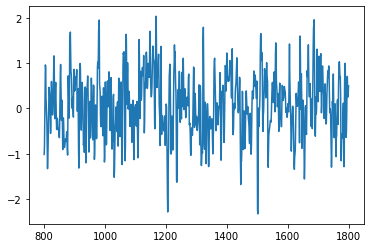

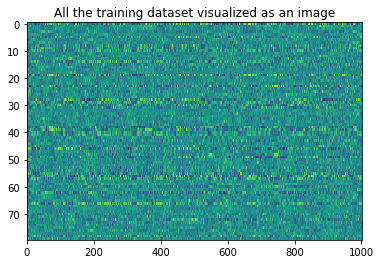

In [5]:
spectrum = x_train[2, 0, :]
Shift_values = np.linspace(800, 1800, 1001)
plt.plot(Shift_values, spectrum)
plt.show()
plt.title('All the training dataset visualized as an image')
plt.imshow(x_train[:, 0, :], aspect='auto')

# Define the neural network, training it and measuring its performance

In [6]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, BatchNorm1d, Conv1d, MaxPool1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [7]:
# hyperameters of the model after hyperparameter search
num_classes = 2
channels = x_train.shape[1]
height = x_train.shape[2]

num_filters_conv1 = 2
kernel_size_conv1 = 12 
stride_conv1 = 17 
padding_conv1 = 0

   
def compute_conv_dim(dim_size, k, p, s):
    return int((dim_size - k + 2 * p) / s + 1)
    
def compute_pool_dim(dim_size, kp, pp, sp):
    return int((dim_size - kp + 2 * pp) / sp + 1)


# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             padding=padding_conv1,
                             stride=stride_conv1)
        self.conv_1_bn = BatchNorm1d(num_filters_conv1)
        torch.nn.init.normal_(self.conv_1.weight)
        self.conv_out_height = compute_conv_dim(height, kernel_size_conv1, padding_conv1, 
                                                                 stride_conv1)
        
        
        self.l1_in_features = num_filters_conv1 * self.conv_out_height 
        
        
        self.l_out = Linear(in_features=self.l1_in_features, 
                            out_features=num_classes,
                            bias=True)
        #torch.nn.init.normal_(self.l_out.weight)
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = relu(self.conv_1_bn(self.conv_1(x))) 
        x = x.view(-1, self.l1_in_features)
        return softmax(self.l_out(x), dim=1)
    
net = Net()
print(net)

Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)


In [8]:
# setting the loss function and tuning gradient descent algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

In [9]:
# Test the forward pass with dummy data from a normal distribution.
x = np.random.normal(0, 1, (5, 1, 1001)).astype('float32')
# print(x.shape)
out = net(Variable(torch.from_numpy(x)))
out.size(), out, out.dtype

(torch.Size([5, 2]), tensor([[0.5298, 0.4702],
         [0.4834, 0.5166],
         [0.5846, 0.4154],
         [0.4953, 0.5047],
         [0.6098, 0.3902]], grad_fn=<SoftmaxBackward>), torch.float32)

In [10]:
from sklearn.metrics import accuracy_score
def train_model(x_train, x_valid, targets_train, targets_valid, epochsnum):
    """
    Trains the neural network, and returns lists of losses on the training and validation set, every 
    epoch, and also the predictions made by the network. All this is packed as a tuple when returning.
    """
    batch_size = 8
    num_epochs = epochsnum
    num_samples_train = x_train.shape[0]
    num_batches_train = int(np.ceil(num_samples_train / float(batch_size)))
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = int(np.ceil(num_samples_valid / float(batch_size)))

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    losses = []
    losses_train=[]
    losses_valid = []


    #creating a numpy array to store the output probabilities
    output_probs=np.ones((1, 3),dtype=np.float32)

    #get_slice = lambda i, size,num_samples: range(i * size, (i + 1) * size)
    get_slice = lambda i, size, num_samples: range(i * size, np.minimum((i + 1) * size,num_samples))

    for epoch in range(num_epochs):
        cur_loss = 0
        net.train()
        for i in range(num_batches_train):
            # FORWARD PASS ----> COMPUTER LOSS ----> TAKE GRADIENT
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))
            output = net(x_batch) # forward pass

            # compute loss and then gradients on the batch
            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()  # gradients computer here
            optimizer.step()
            cur_loss += batch_loss.data.numpy()   
        losses.append(cur_loss / num_batches_train)

        net.eval()
        #Evaluating training
        train_preds, train_targs = [], []
        cur_loss=0
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size, num_samples_train)
            x_batch = Variable(torch.from_numpy(x_train[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            train_targs += list(targets_train[slce])
            train_preds += list(preds.data.numpy())

            target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
            batch_loss = criterion(output, target_batch)

            cur_loss += batch_loss.data.numpy()
        losses_train.append(cur_loss / (num_batches_train))

        ### Evaluate validation
        val_preds, val_targs = [], []
        cur_loss = 0
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size, num_samples_valid)
            x_batch = Variable(torch.from_numpy(x_valid[slce]))

            output = net(x_batch)
            preds = torch.max(output, 1)[1]

            val_preds += list(preds.data.numpy())
            val_targs += list(targets_valid[slce])

            target_batch = Variable(torch.from_numpy(targets_valid[slce]).long())
            batch_loss = criterion(output, target_batch)         
            cur_loss += batch_loss.data.numpy()
        losses_valid.append(cur_loss / num_batches_valid)


            #Taking the output probabilities and storing them in a numpy array
            #output_probs=np.append(output_probs,output.data.numpy(),axis=0)

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        if epoch % 50 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Acc', 'Val Acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.show()

    plt.figure()
    plt.plot(losses_train, 'r')
    plt.plot(losses_valid, 'b')
    plt.legend(['Train', 'Valid'])
    plt.show()
    return (val_targs, val_preds, losses_train, losses_valid)
    

In [11]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4900, 0.5100],
        [0.5932, 0.4068],
        [0.5462, 0.4538],
        [0.5415, 0.4585],
        [0.5671, 0.4329]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.715876 , Train acc 0.460317, Valid acc 0.411765
Epoch 51 : Train Loss 0.426058 , Train acc 0.904762, Valid acc 0.882353


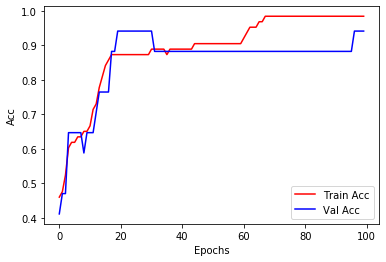

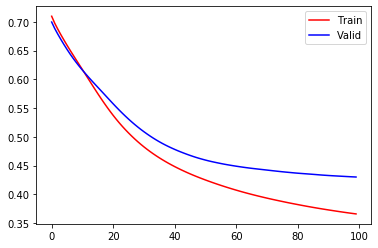

[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.5336, 0.4664],
        [0.4396, 0.5604],
        [0.4977, 0.5023],
        [0.5761, 0.4239],
        [0.5094, 0.4906]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.691350 , Train acc 0.531250, Valid acc 0.750000
Epoch 51 : Train Loss 0.408358 , Train acc 0.968750, Valid acc 0.812500


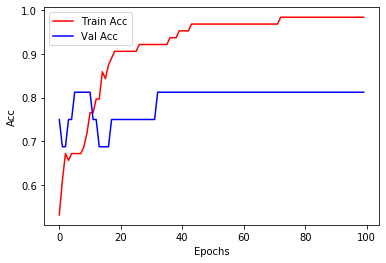

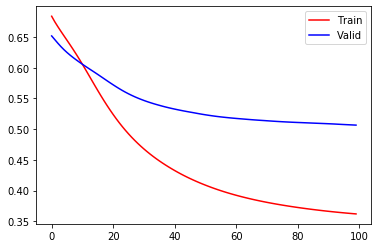

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4310, 0.5690],
        [0.4965, 0.5035],
        [0.4341, 0.5659],
        [0.4670, 0.5330],
        [0.6340, 0.3660]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.675241 , Train acc 0.703125, Valid acc 0.750000
Epoch 51 : Train Loss 0.413945 , Train acc 0.953125, Valid acc 0.625000


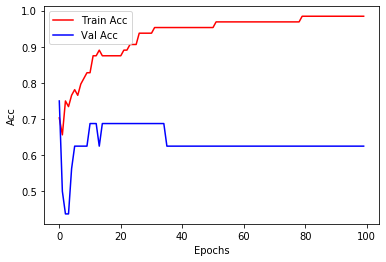

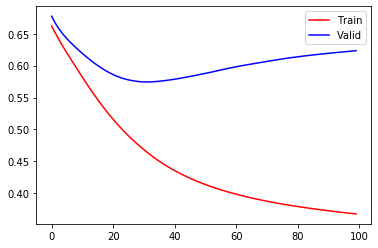

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]
[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4765, 0.5235],
        [0.7017, 0.2983],
        [0.4688, 0.5312],
        [0.4312, 0.5688],
        [0.4140, 0.5860]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.698683 , Train acc 0.515625, Valid acc 0.500000
Epoch 51 : Train Loss 0.401068 , Train acc 0.968750, Valid acc 0.812500


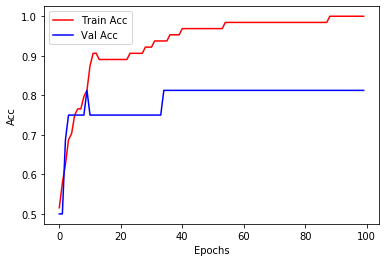

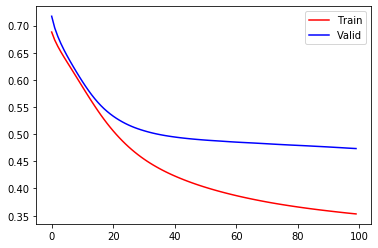

[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
torch.Size([5, 2]) tensor([[0.4903, 0.5097],
        [0.4186, 0.5814],
        [0.5281, 0.4719],
        [0.3180, 0.6820],
        [0.5897, 0.4103]], grad_fn=<SoftmaxBackward>) torch.float32
Epoch  1 : Train Loss 0.686533 , Train acc 0.600000, Valid acc 0.466667
Epoch 51 : Train Loss 0.39

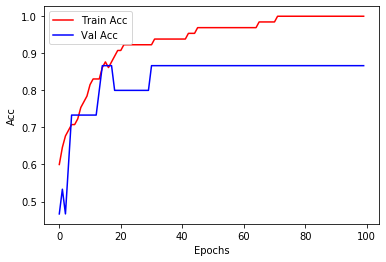

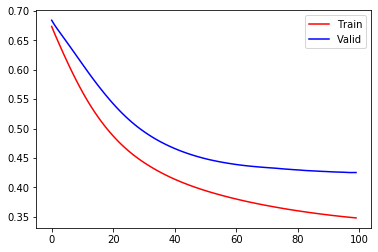

[1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]


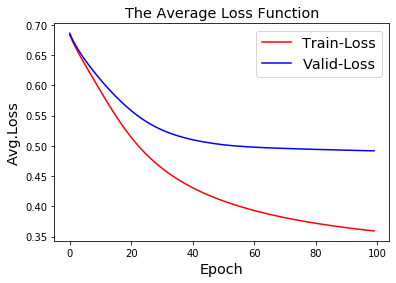

0.8125


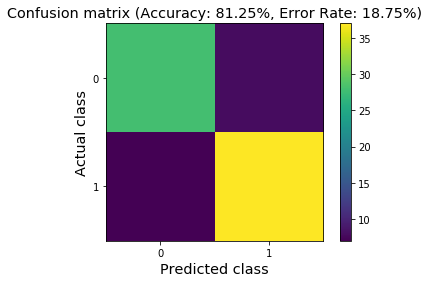

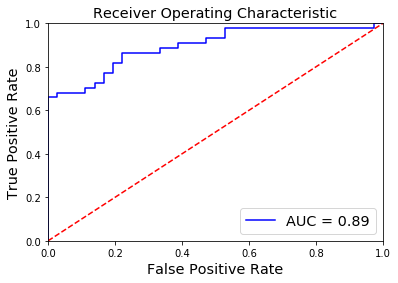

In [16]:
# Cross Validation to get an unbiased estimate on the models generalisation error
cv = StratifiedKFold(n_splits=5)
Validation_Targets = []
Validation_Preds = []
Total_Loss_Train = np.zeros(100)
Total_Loss_Valid = np.zeros(100)
All_Probabilities = []
for train,test in cv.split(x_train,targets_train):
    Train_Data = x_train[train]
    Train_targets = targets_train[train]
    Test_Data = x_train[test]
    Test_targets = targets_train[test]
    net = Net()
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
    x = np.random.normal(0, 1, (5, 1, 1001)).astype('float32')
    #print(x.shape)
    out = net(Variable(torch.from_numpy(x)))
    print(out.size(), out, out.dtype)
    val_targs, val_preds, losses_train, losses_valid=train_model(Train_Data, Test_Data, Train_targets, Test_targets, 100)
    print(val_preds)
    print(val_targs)
    Validation_Targets += list(val_targs)
    Validation_Preds += list(val_preds)
    print(Validation_Targets) 
    print(Validation_Preds) 
    Losses_Train_Array=np.asarray(losses_train)
    Losses_Valid_Array=np.asarray(losses_valid)
    Total_Loss_Train = Total_Loss_Train + Losses_Train_Array
    Total_Loss_Valid = Total_Loss_Valid + Losses_Valid_Array
    Preds_Probabilities=net(Variable(torch.from_numpy(Test_Data))).data.numpy()
    All_Probabilities += list(Preds_Probabilities[:,1])

plt.figure()
plt.title('The Average Loss Function',fontsize='x-large')
plt.plot(Total_Loss_Train/5,'r')
plt.plot(Total_Loss_Valid/5,'b')
plt.xlabel('Epoch',fontsize='x-large')
plt.ylabel('Avg.Loss',fontsize='x-large')
plt.legend(['Train-Loss','Valid-Loss'],fontsize='x-large')
plt.savefig('Images/LossFunction_CNN_ShallowNetwork.png')
plt.show()

print(accuracy_score(Validation_Targets,Validation_Preds))

# Plotting the ROC, AUC curve and the confusion matrix
from sklearn.metrics import confusion_matrix

C=num_classes
cm = confusion_matrix(Validation_Targets, Validation_Preds);
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
plt.figure(2);
plt.imshow(cm, interpolation='None');
plt.colorbar()
plt.xticks(range(C)); plt.yticks(range(C));
plt.xlabel('Predicted class',fontsize='x-large'); plt.ylabel('Actual class',fontsize='x-large');
plt.title('Confusion matrix (Accuracy: {:4.2f}%, Error Rate: {:4.2f}%)'.format(accuracy, error_rate),fontsize='x-large');
plt.savefig('Images/ConfusionMatrix_CNN_ShallowNetwork.png')
plt.show()

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Validation_Targets, All_Probabilities)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize='x-large')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize='x-large')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.savefig('Images/ROCCurve_CNN_ShallowNetwork.png')
plt.show()

    

In [17]:
cm

array([[28,  8],
       [ 7, 37]])

# Student-t distribution test for comparison

CV-fold 1 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.690851 , Train acc 0.555556, Valid acc 0.500000
Epoch 51 : Train Loss 0.412095 , Train acc 0.916667, Valid acc 0.875000


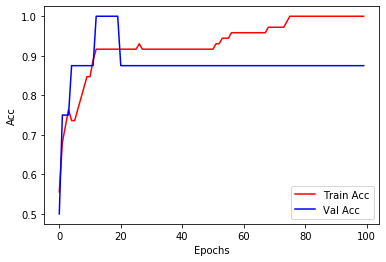

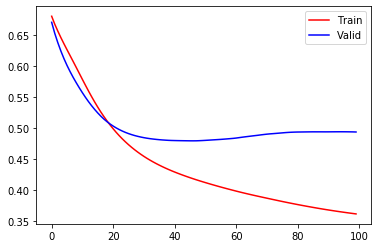

CV-fold 2 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.689190 , Train acc 0.541667, Valid acc 0.250000
Epoch 51 : Train Loss 0.398525 , Train acc 0.972222, Valid acc 0.875000


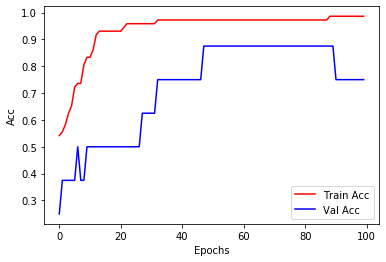

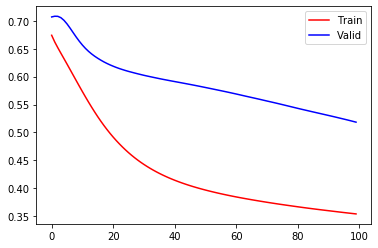

CV-fold 3 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.700640 , Train acc 0.472222, Valid acc 0.500000
Epoch 51 : Train Loss 0.401446 , Train acc 0.958333, Valid acc 0.750000


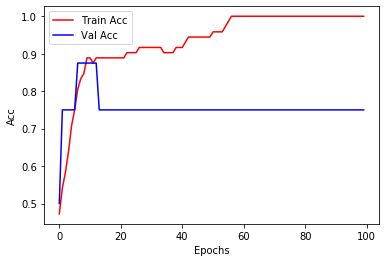

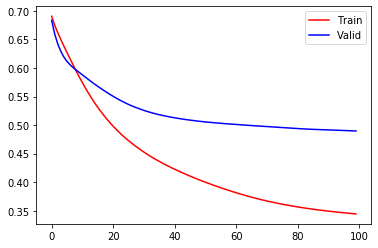

CV-fold 4 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.685301 , Train acc 0.541667, Valid acc 0.375000
Epoch 51 : Train Loss 0.423715 , Train acc 0.930556, Valid acc 0.750000


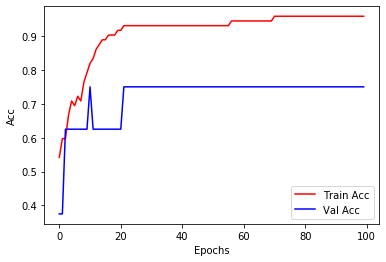

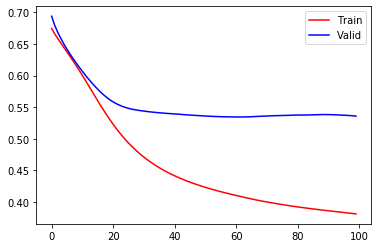

CV-fold 5 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.692868 , Train acc 0.611111, Valid acc 0.625000
Epoch 51 : Train Loss 0.412347 , Train acc 0.930556, Valid acc 0.875000


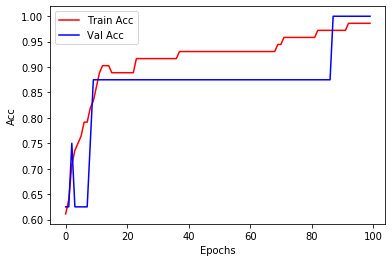

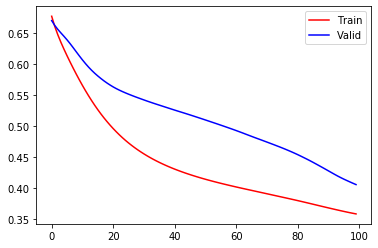

CV-fold 6 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.693478 , Train acc 0.486111, Valid acc 0.375000
Epoch 51 : Train Loss 0.398428 , Train acc 0.986111, Valid acc 0.750000


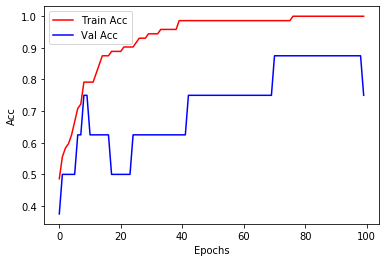

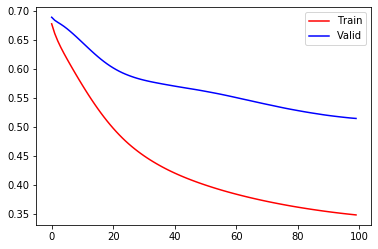

CV-fold 7 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.694313 , Train acc 0.652778, Valid acc 0.625000
Epoch 51 : Train Loss 0.436509 , Train acc 0.916667, Valid acc 0.875000


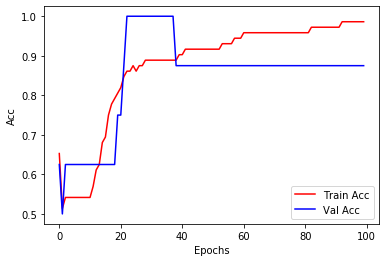

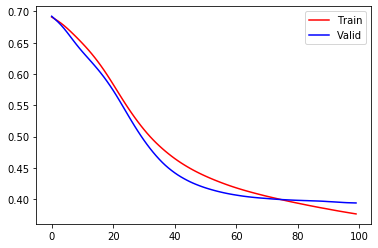

CV-fold 8 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.692663 , Train acc 0.652778, Valid acc 0.625000
Epoch 51 : Train Loss 0.423920 , Train acc 0.958333, Valid acc 0.750000


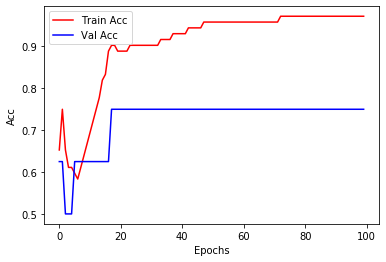

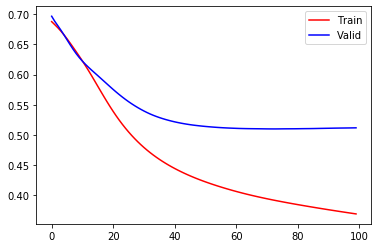

CV-fold 9 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.675829 , Train acc 0.652778, Valid acc 0.500000
Epoch 51 : Train Loss 0.402499 , Train acc 0.972222, Valid acc 0.875000


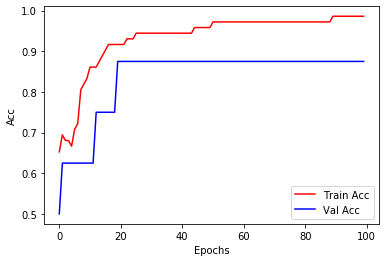

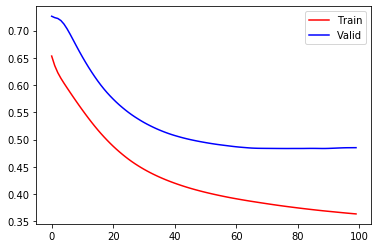

CV-fold 10 of 10
Net(
  (conv_1): Conv1d(1, 2, kernel_size=(12,), stride=(17,))
  (conv_1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=118, out_features=2, bias=True)
)
Epoch  1 : Train Loss 0.684158 , Train acc 0.583333, Valid acc 0.750000
Epoch 51 : Train Loss 0.403193 , Train acc 0.986111, Valid acc 1.000000


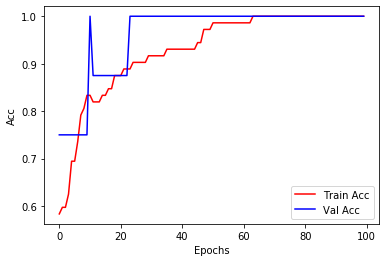

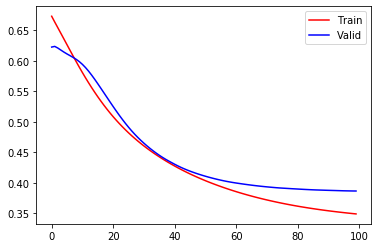

Classifiers are not significantly different


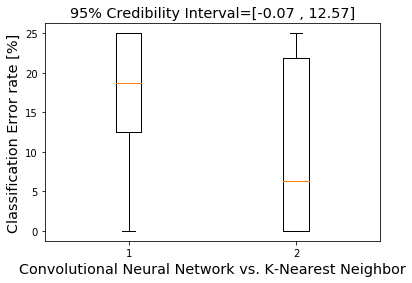

In [18]:
#Model Comparison using student t-distribution
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = KFold(n_splits=K)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_Cnn = np.empty((K,1))
Error_Knn = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(x_train,targets_train):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = x_train[train_index,:]
    y_train = targets_train[train_index]
    X_test = x_train[test_index,:]
    y_test = targets_train[test_index]

    # Fit and evaluate CNN classifier
    net=Net()
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0.01)
    _,y_cnn,_,_=train_model(X_train,X_test,y_train,y_test,100)
    #model = lm.logistic.LogisticRegression(C=N)
    #model = model.fit(X_train, y_train)
    #y_logreg = model.predict(X_test)
    Error_Cnn[k] = 100*(y_cnn!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate K Nearest Neighbor classifier
    knclassifier = KNeighborsClassifier(n_neighbors=1);
    X_train=X_train.reshape((-1,rows))
    X_test=X_test.reshape((-1,rows))
    knclassifier.fit(X_train, y_train);
    y_knn = knclassifier.predict(X_test) ;
    #model2 = tree.DecisionTreeClassifier()
    #model2 = model2.fit(X_train, y_train)
    #y_dectree = model2.predict(X_test)
    Error_Knn[k] = 100*(y_knn!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_Cnn-Error_Knn)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
plt.figure()
plt.title('95% Credibility Interval=[{:4.2f} , {:4.2f}]'.format(zL,zH),fontsize='x-large')
plt.boxplot(np.concatenate((Error_Cnn, Error_Knn),axis=1))
#plt.yticks(range(0,110,10))
plt.xlabel('Convolutional Neural Network vs. K-Nearest Neighbor',fontsize='x-large')
plt.ylabel('Classification Error rate [%]',fontsize='x-large')
plt.savefig('Images/CNN_KNN_Comparison_BCD.png')
plt.show()


# Visualising the learned convolutional layers in frequency domain 

In [ ]:
# Visualising the filters and the feature maps
# Taking a sample first
sample_spec = x_test[0]
print("The shape of sample spectrum",sample_spec.shape)
plt.plot(Shift_values,sample_spec[0,:])
sample_spec=sample_spec.reshape(-1,1,1001)
a=net(torch.from_numpy(sample_spec))
print("The output of the neural network is:",a.data)


In [ ]:
from torch.nn.functional import conv1d
input_tensor=torch.from_numpy(sample_spec)
filter1=net.conv_1.weight.data
Output_convolution=relu(net.conv_1(input_tensor))
print("The Feature maps generated after the convolution operation is:",Output_convolution.shape)
print("The filters have a tensor size of",filter1.shape)
print("The Bias Term:",net.conv_1.bias.data)

In [ ]:
plt.figure()
for i in range(Output_convolution.shape[1]):
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(Output_convolution[0,i,:].data.numpy())
plt.show()    

plt.figure()
plt.title("The Filters visualised on a graph")
for i in range(filter1.shape[0]):
    plt.title("")
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(filter1[i,0,:].data.numpy())
plt.show()

In [ ]:
#Trying to plot the filters in the frequncy domain
from scipy.signal import freqz

for i in range(filter1.shape[0]):
    w,h=freqz(np.flip(filter1[i,0,:].data.numpy()))
    plt.plot(w,20*np.log10(abs(h)),'b')
    plt.show()
    
print("This is the transfer function of the system")
print(type(sample_spec))
#w_input,h_input=freqz(sample_spec[0,0,:])
#plt.title("The input signal in the frequency domain")
#plt.plot(w_input,20*np.log10(abs(h_input)))